In [1]:
from __future__ import print_function
import keras
from keras.optimizers import SGD
from keras.layers import add, Flatten, MaxPooling2D, Dropout, ZeroPadding2D
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [2]:
#Load Cifar-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train
# Normalize data.
input_shape = x_train.shape[1:]
def normalizer(x_train, x_test):
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    return x_train, x_test

# If subtract pixel mean is enabled
def subtract_pixel_mean(x_train, x_test):
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
    return x_train, x_test

def print_info(x_train, y_train, x_test):
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)



# Convert class vectors to binary class matrices.
def label_binary(y_train, y_test, num_classes):
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return y_train, y_test
print_info(x_train, y_train, x_test)
(x_train, x_test)=normalizer(x_train, x_test)
#(x_train, x_test)=subtract_pixel_mean(x_train, x_test)
(y_train, y_test)=label_binary(y_train, y_test, 10)
print_info(x_train, y_train, x_test)
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)


In [3]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [6]:
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1, 1), padding='same', name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None

    x = Conv2D(nb_filter, kernel_size, padding=padding, strides=strides, activation='relu', name=conv_name)(x)
    x = BatchNormalization(axis=3, name=bn_name)(x)
    return x
    
def identity_Block(inpt, nb_filter, kernel_size, strides=(1, 1), with_conv_shortcut=False):
    x = Conv2d_BN(inpt, nb_filter=nb_filter, kernel_size=kernel_size, strides=strides, padding='same')
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size, padding='same')
    if with_conv_shortcut:
        shortcut = Conv2d_BN(inpt, nb_filter=nb_filter, strides=strides, kernel_size=kernel_size)
        x = add([x, shortcut])
        return x
    else:
        x = add([x, inpt])
        return x

def bottleneck_Block(inpt, nb_filters, strides=(1, 1), with_conv_shortcut=False):
        k1, k2, k3 = nb_filters
        x = Conv2d_BN(inpt, nb_filter=k1, kernel_size=1, strides=strides, padding='same')
        x = Conv2d_BN(x, nb_filter=k2, kernel_size=3, padding='same')
        x = Conv2d_BN(x, nb_filter=k3, kernel_size=1, padding='same')
        if with_conv_shortcut:
            shortcut = Conv2d_BN(inpt, nb_filter=k3, strides=strides, kernel_size=1)
            x = add([x, shortcut])
            return x
        else:
            x = add([x, inpt])
            return x

In [4]:
def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
    

In [5]:
model = resnet_v1(input_shape=input_shape, depth=20)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

W0920 18:11:08.635461  7332 deprecation_wrapper.py:119] From C:\Users\qq149\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 18:11:08.700320  7332 deprecation_wrapper.py:119] From C:\Users\qq149\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 18:11:08.714248  7332 deprecation_wrapper.py:119] From C:\Users\qq149\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0920 18:11:08.758130  7332 deprecation_wrapper.py:119] From C:\Users\qq149\.conda\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session ins

Learning rate:  0.001


In [15]:

models=model.fit(x_train, y_train,
              batch_size=32,
              epochs=10,
          validation_data=(x_test, y_test),
              )




Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 85s 2ms/step - loss: 0.5475 - acc: 0.8820 - val_loss: 1.0690 - val_acc: 0.7349
Epoch 2/10
50000/50000 [==============================] - 96s 2ms/step - loss: 0.5302 - acc: 0.8906 - val_loss: 1.0079 - val_acc: 0.7644
Epoch 3/10
50000/50000 [==============================] - 83s 2ms/step - loss: 0.5133 - acc: 0.8993 - val_loss: 1.2349 - val_acc: 0.7159
Epoch 4/10
50000/50000 [==============================] - 84s 2ms/step - loss: 0.5035 - acc: 0.9059 - val_loss: 0.9721 - val_acc: 0.7712
Epoch 5/10
50000/50000 [==============================] - 86s 2ms/step - loss: 0.4939 - acc: 0.9076 - val_loss: 1.1680 - val_acc: 0.7346
Epoch 6/10
50000/50000 [==============================] - 89s 2ms/step - loss: 0.4834 - acc: 0.9141 - val_loss: 0.9821 - val_acc: 0.7811
Epoch 7/10
50000/50000 [==============================] - 89s 2ms/step - loss: 0.4756 - acc: 0.9173 - val_loss: 1.1618 - val_acc

In [45]:
datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                        validation_data=(x_test, y_test),
                    steps_per_epoch=1,
                        epochs=200, verbose=1, workers=4)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (50000, 10))

[INFO] Evaluating model
              precision    recall  f1-score   support

    airplane       0.90      0.72      0.80      1000
  automobile       0.86      0.91      0.89      1000
        bird       0.84      0.56      0.68      1000
         cat       0.66      0.38      0.48      1000
        deer       0.85      0.62      0.71      1000
         dog       0.42      0.93      0.58      1000
        frog       0.87      0.76      0.81      1000
       horse       0.80      0.80      0.80      1000
        ship       0.87      0.88      0.87      1000
       truck       0.83      0.89      0.86      1000

    accuracy                           0.75     10000
   macro avg       0.79      0.75      0.75     10000
weighted avg       0.79      0.75      0.75     10000

[[719  20  27  20   3  57   5  25  71  53]
 [  4 912   2   1   0  15   1   4   6  55]
 [ 30  10 565  45  45 224  37  20  12  12]
 [  6   6  17 378  18 496  40  14  10  15]
 [  9   5  23  27 618 187  20  94  13   4]
 [

ValueError: x and y must have same first dimension, but have shapes (200,) and (10,)

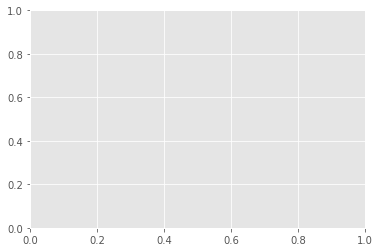

In [18]:
predictions = model.predict(x_test, batch_size=16)
print('[INFO] Evaluating model')
from sklearn.metrics import classification_report
result = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1),
                            target_names=['airplane', 'automobile', 'bird',
                                          'cat','deer','dog','frog','horse','ship','truck'])
print(result)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)
name1='class_report'
with open(str(name1)+".txt", "w") as f:
    f.write(result)
name3='cm'
#with open(str(name3)+".txt", "w") as f:
#    f.write(cm)
import matplotlib.pyplot as plt


N = np.arange(0, 200)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, models.history['loss'], label='train_loss')
plt.plot(N, models.history['val_loss'], label='val_loss')
#plt.plot(N, models.history['acc'], label='train_acc')
#plt.plot(N, models.history['val_acc'], label='val_acc')
plt.title('Training loss and Accuracy')
plt.xlabel('epoch #')
plt.ylabel('loss/accuracy')
plt.ylim((0, 10))
plt.legend()
name2='img'
plt.savefig(str(name2)+'.png')
#model.save(sys.args['model'])